In [2]:
# Data Source: https://www.kaggle.com/datasets/simolopes/wikiart-all-artpieces

In [3]:
# ==============================================================================
# Part 1: Setup and Library Imports
# ==============================================================================
print("--- Part 1: Setting up and importing libraries ---")

# --- Core Data Science and System Libraries ---
import os
import pandas as pd
import numpy as np
import warnings
from PIL import Image
import shutil
import psutil
from google.colab import drive
from tqdm.notebook import tqdm
import pickle

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Deep Learning for Feature Extraction ---
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# --- Machine Learning Models and Utilities ---
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.\n")


--- Part 1: Setting up and importing libraries ---
Libraries imported successfully.



In [6]:
# ==============================================================================
# Part 2: Data Loading and Preparation
# ==============================================================================
print("--- Part 2: Mounting Drive and preparing data ---")

# --- Mount Google Drive and Set Up Paths ---
drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/MyDrive/AI_Art_Advisor_Project'
os.makedirs(PROJECT_PATH, exist_ok=True)
os.chdir(PROJECT_PATH)

# --- Load and Prepare Data ---
CSV_PATH = 'wikiart_art_pieces.csv'
IMAGE_DIR = os.path.join(PROJECT_PATH, 'wikiart', 'wikiart')

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    df.columns = df.columns.str.strip()
    df.dropna(subset=['style', 'file_name'], inplace=True)
    df['filepath'] = df['file_name'].apply(lambda x: os.path.join(IMAGE_DIR, x))

    df_filtered = df[df['style'] != 'Unknown'].copy()
    N_STYLES = 15
    top_styles = df_filtered['style'].value_counts().nlargest(N_STYLES).index
    df_subset = df_filtered[df_filtered['style'].isin(top_styles)].copy()
    df_balanced = df_subset.groupby('style').sample(n=2000, random_state=42).reset_index(drop=True)

    art_df = df_balanced[['filepath', 'style']].copy()
    print(f"Created a balanced subset of {len(art_df)} images from {N_STYLES} styles.")

    # --- Verify and Clean Image Files (with Caching) ---
    CLEAN_CSV_PATH = 'wikiart_verified_files.csv'

    if os.path.exists(CLEAN_CSV_PATH):
        print(f"Loading pre-verified image list from {CLEAN_CSV_PATH}...")
        clean_art_df = pd.read_csv(CLEAN_CSV_PATH)
        print(f"Loaded {len(clean_art_df)} valid image paths.\n")
    else:
        print("No pre-verified file list found. Scanning all images (this will take a while)...")
        valid_filepaths = []
        for filepath in tqdm(art_df['filepath'], desc="Verifying Images"):
            if os.path.exists(filepath):
                try:
                    img = Image.open(filepath)
                    img.verify()
                    valid_filepaths.append(filepath)
                except (IOError, SyntaxError):
                    pass

        clean_art_df = art_df[art_df['filepath'].isin(valid_filepaths)].copy()

        # Save the clean dataframe for the next run
        clean_art_df.to_csv(CLEAN_CSV_PATH, index=False)
        print(f"\nScan complete. Found {len(clean_art_df)} valid images and saved list to {CLEAN_CSV_PATH}.\n")
else:
    print("CSV file not found. Please ensure it's in your project directory.")


--- Part 2: Mounting Drive and preparing data ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created a balanced subset of 30000 images from 15 styles.
No pre-verified file list found. Scanning all images (this will take a while)...


Verifying Images:   0%|          | 0/30000 [00:00<?, ?it/s]


Scan complete. Found 29907 valid images and saved list to wikiart_verified_files.csv.



In [7]:
# ==============================================================================
# Part 3: Feature Extraction
# ==============================================================================
print("--- Part 3: Building feature extractor ---")

# --- Build Feature Extractor Model ---
# This model takes the pre-trained EfficientNetV2B0 and adds a pooling layer
# to create a feature vector for each image.
IMG_SIZE = (224, 224)
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False

# Create the feature extractor by adding a GlobalAveragePooling2D layer to the base model's output
pooled_output = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=pooled_output)

print("Feature extractor model created successfully.")


--- Part 3: Building feature extractor ---
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Feature extractor model created successfully.


In [8]:
# ==============================================================================
# Part 3.1: Extract and Save Features
# ==============================================================================
print("\n--- Extracting and saving features ---")

# --- Extract Features (or load if already extracted) ---
# This saves time by not re-extracting features on every run.
FEATURES_FILE = 'art_style_features_efficientnet.npz'
if not os.path.exists(FEATURES_FILE):
    print(f"Extracting features from {len(clean_art_df)} images...")
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = datagen.flow_from_dataframe(
        dataframe=clean_art_df, x_col='filepath', y_col='style',
        target_size=IMG_SIZE, batch_size=32, class_mode='categorical', shuffle=False
    )
    features = feature_extractor.predict(generator, steps=len(generator), verbose=1)
    labels = clean_art_df['style'].values
    np.savez(FEATURES_FILE, features=features, labels=labels)
    print(f"Features and labels saved to {FEATURES_FILE}")
else:
    print(f"Loading pre-extracted features from {FEATURES_FILE}...")
    # CORRECTED: Added allow_pickle=True to load the object array of labels
    data = np.load(FEATURES_FILE, allow_pickle=True)
    features = data['features']
    labels = data['labels']

print(f"Feature shape: {features.shape}, Labels shape: {labels.shape}\n")


--- Extracting and saving features ---
Loading pre-extracted features from art_style_features_efficientnet.npz...
Feature shape: (29907, 2560), Labels shape: (29907,)



In [9]:
# ==============================================================================
# Part 4: Training and Evaluating the Machine Learning Ensemble
# ==============================================================================
print("--- Part 4: Training and evaluating the ML model ensemble ---")

# --- Prepare Data for ML Models ---
le = LabelEncoder()
y = le.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Hyperparameter Tuning for SVM ---
print("--- Performing GridSearchCV for Support Vector Machine ---")
param_grid = {'C': [1, 10, 50], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}
grid_search = GridSearchCV(SVC(random_state=42, probability=True), param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_svm = grid_search.best_estimator_
print(f"\nBest SVM parameters found: {grid_search.best_params_}\n")

# --- Define, Train, and Evaluate Ensemble ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": best_svm,
    "K-Nearest Neighbors": KNeighborsClassifier()
}

results = []
for name, model_instance in models.items():
    print(f"--- Evaluating {name} ---")
    if name == "Support Vector Machine":
        mean_cv_accuracy = grid_search.best_score_
    else:
        cv_scores = cross_val_score(model_instance, X_train_scaled, y_train, cv=5, scoring='accuracy')
        mean_cv_accuracy = np.mean(cv_scores)
        model_instance.fit(X_train_scaled, y_train)

    y_pred = model_instance.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True, target_names=le.classes_)
    results.append({
        "Model": name, "Cross-Validation Accuracy": mean_cv_accuracy, "Test Accuracy": report['accuracy'],
        "Precision (Weighted Avg)": report['weighted avg']['precision'], "Recall (Weighted Avg)": report['weighted avg']['recall'],
        "F1-Score (Weighted Avg)": report['weighted avg']['f1-score']
    })

results_df = pd.DataFrame(results)
print("\n--- Model Comparison ---")
print(results_df)
print("\n")


--- Part 4: Training and evaluating the ML model ensemble ---
--- Performing GridSearchCV for Support Vector Machine ---
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best SVM parameters found: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

--- Evaluating Logistic Regression ---
--- Evaluating Naive Bayes ---
--- Evaluating Decision Tree ---
--- Evaluating Random Forest ---
--- Evaluating Support Vector Machine ---
--- Evaluating K-Nearest Neighbors ---

--- Model Comparison ---
                    Model  Cross-Validation Accuracy  Test Accuracy  \
0     Logistic Regression                   0.371118       0.368773   
1             Naive Bayes                   0.324830       0.326647   
2           Decision Tree                   0.164326       0.164493   
3           Random Forest                   0.328843       0.338794   
4  Support Vector Machine                   0.473774       0.479996   
5     K-Nearest Neighbors                   0.324591       0.330882   

   Pr

--- Part 5: Visualizing performance and running K-Means ---


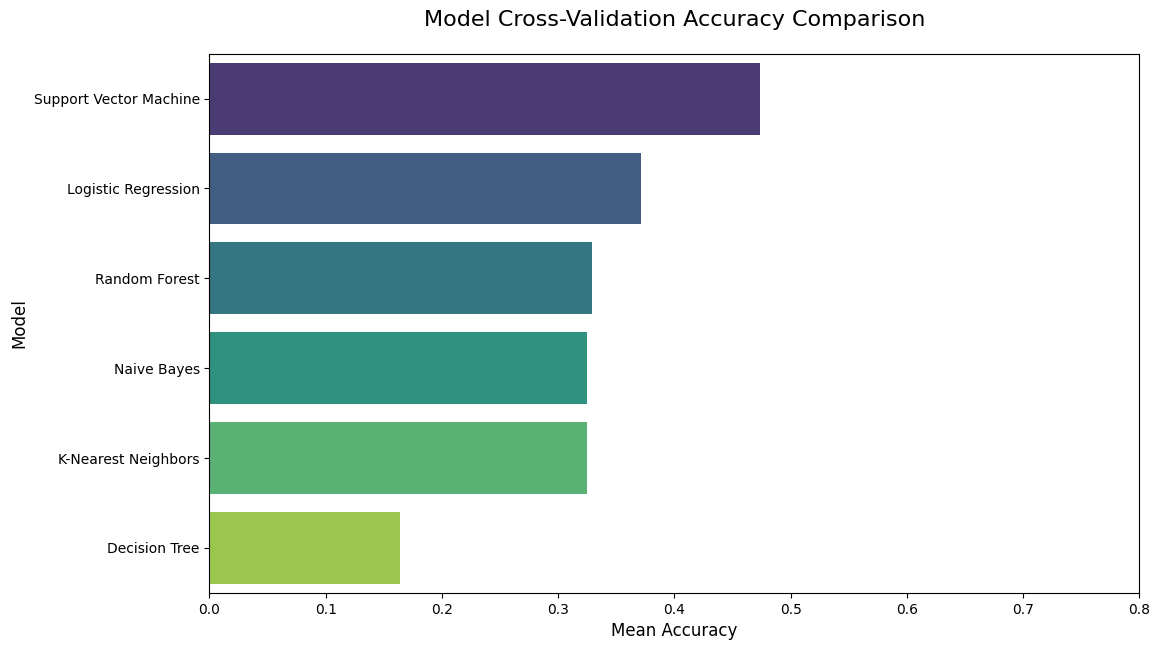

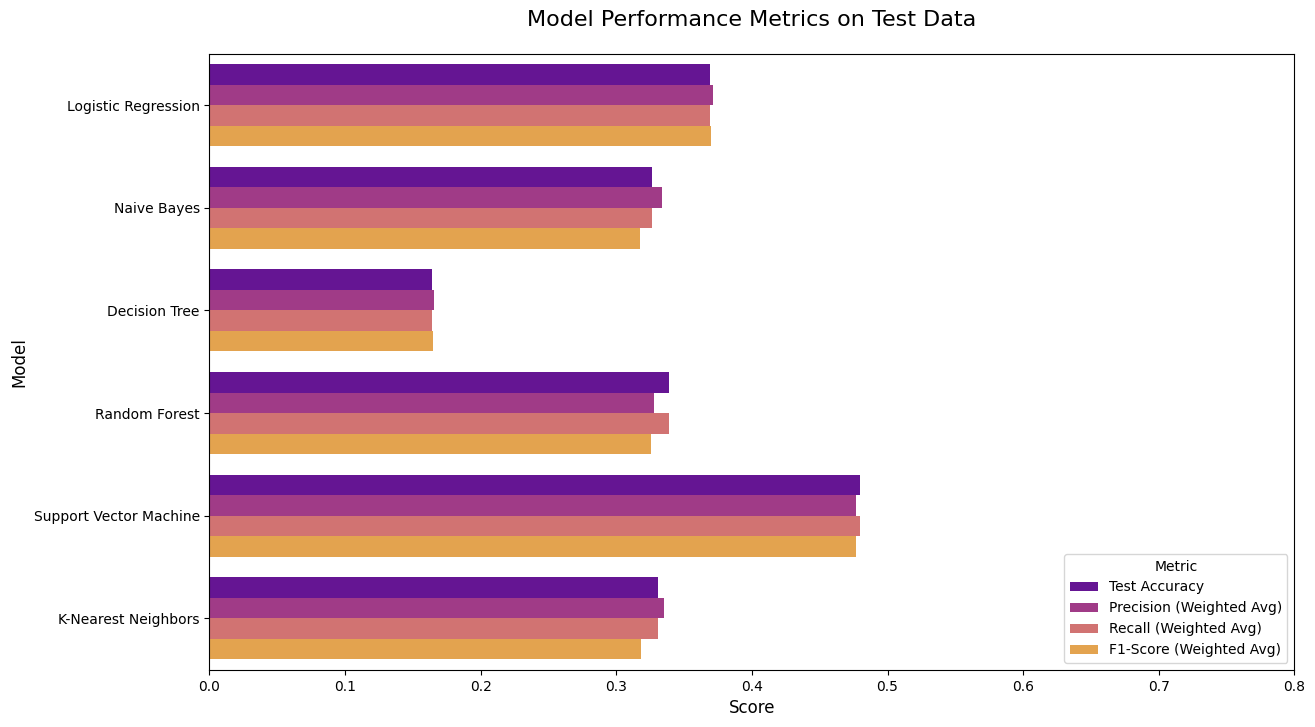

Testing K values for K-Means:   0%|          | 0/14 [00:00<?, ?it/s]

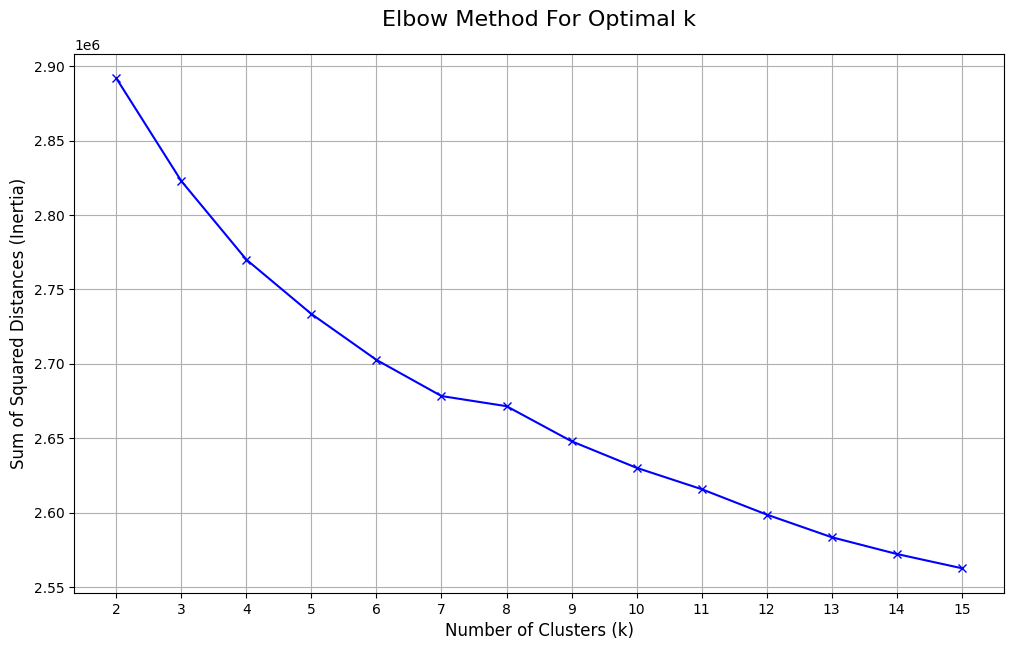

In [13]:
# ==============================================================================
# Part 5: Data Visualization and K-Means Clustering
# ==============================================================================
print("--- Part 5: Visualizing performance and running K-Means ---")

# --- Plot 1: Cross-Validation Accuracy Comparison ---
plt.figure(figsize=(12, 7))
sns.barplot(x="Cross-Validation Accuracy", y="Model", data=results_df.sort_values("Cross-Validation Accuracy", ascending=False), palette="viridis")
plt.title("Model Cross-Validation Accuracy Comparison", fontsize=16, pad=20)
plt.xlabel("Mean Accuracy", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xlim(0, 0.8)
plt.show()

# --- Plot 2: Detailed Test Metrics Comparison ---
metrics_df = results_df.melt(id_vars="Model", value_vars=["Test Accuracy", "Precision (Weighted Avg)", "Recall (Weighted Avg)", "F1-Score (Weighted Avg)"])
plt.figure(figsize=(14, 8))
sns.barplot(x="value", y="Model", hue="variable", data=metrics_df, palette="plasma")
plt.title("Model Performance Metrics on Test Data", fontsize=16, pad=20)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xlim(0, 0.8)
plt.legend(title="Metric", loc='lower right')
plt.show()

# --- Elbow Method for K-Means ---
sum_of_squared_distances = []
K = range(2, 16)
for k in tqdm(K, desc="Testing K values for K-Means"):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(features)
    sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(12, 7))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Sum of Squared Distances (Inertia)', fontsize=12)
plt.title('Elbow Method For Optimal k', fontsize=16, pad=20)
plt.xticks(K)
plt.grid(True)
plt.show()
print("\n")


In [14]:
# --- K-Means Cluster Analysis ---
OPTIMAL_K = 7 # Or another value based on your elbow plot interpretation

print(f"\\n--- Analyzing clusters with k={OPTIMAL_K} ---")
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init='auto').fit(features)
# Create a dataframe to compare true labels with cluster labels
cluster_df = pd.DataFrame({'True_Style': labels, 'Cluster_ID': kmeans.labels_})

# Display a cross-tabulation to see how styles are grouped
print("Cross-tabulation of True Art Styles vs. K-Means Cluster ID:")
print(pd.crosstab(cluster_df['True_Style'], cluster_df['Cluster_ID']))

\n--- Analyzing clusters with k=7 ---
Cross-tabulation of True Art Styles vs. K-Means Cluster ID:
Cluster_ID                0    1     2    3    4    5    6
True_Style                                                
Abstract Expressionism   17   82  1306  126  443   24    2
Art Nouveau (Modern)    134  726   347  127  298  191  173
Baroque                 126  228    73  189  252  681  447
Cubism                   61  686   685   57  382   98   27
Expressionism            92  595   449  148  304  208  199
Impressionism           248  147   101  767  339  173  218
Neoclassicism           303  280   115  136  407  237  510
Northern Renaissance    135  350   132   94  290  592  388
Pop Art                  50  427   679   32  652   50  110
Post-Impressionism      310  377   224  513  248  148  173
Realism                 115  281    78  529  370  212  408
Rococo                  143  127    58  119  183  466  893
Romanticism             161  208    34  569  275  374  371
Surrealism       

In [15]:
# ==============================================================================
# Part 6: Saving Final Model for Deployment
# ==============================================================================
print("--- Part 6: Saving the best model for deployment ---")

best_model_name = "Support Vector Machine (Optimized)"
with open('best_model.pkl', 'wb') as f: pickle.dump(best_svm, f)
with open('scaler.pkl', 'wb') as f: pickle.dump(scaler, f)
with open('label_encoder.pkl', 'wb') as f: pickle.dump(le, f)

print(f"'{best_model_name}' model, scaler, and label encoder saved successfully.")


--- Part 6: Saving the best model for deployment ---
'Support Vector Machine (Optimized)' model, scaler, and label encoder saved successfully.
